In [1]:
import writefile_run as writefile_run

In [2]:
%%writefile_run som_knn.py

import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize

#torch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

#importing sklearn libraries
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import datetime as dt
import time
import os


# Importing db properties and writer args python files as modules
import db_properties as db_props
import writer_configs as write_args
import psycopg2

from preprocessors import *
from data_handler import *
import som_knn_detector as som_detector

import error_codes as error_codes
import type_checker as type_checker
import json
import traceback


import warnings
warnings.filterwarnings('ignore')

rcParams['figure.figsize'] = 12, 9
rcParams[ 'axes.grid']=True

In [3]:
import pylab as pl
from IPython import display 

In [4]:
% matplotlib inline
%load_ext autoreload
%autoreload 2

# Learning

In [5]:
ideal_kwargs_type  = {
            'som_shape':tuple,
            'input_feature_size':int,
            'time_constant':float,
            'minNumPerBmu':int,
            'no_of_neighbors':int,
            'initial_radius':float,
            'initial_learning_rate':float,
            'n_iterations':int,
            'N':int,    
            'diff_order':int,
            'is_train':bool,
            'epochs':int,
            'batch_size':int,
            'to_plot':bool,
            'test_frac':float
        }

In [6]:
%%writefile_run som_knn_wrapper_sprint1.py -a


def main(assetno,from_timestamp,to_timestamp,con,para_list,source_type='opentsdb',table_name='',
        qry_str='',impute_fill_method='forward',down_sampling_method=None,down_sampling_window=None,freq=None,
        resample_fill_method=None,to_resample=None,to_impute=None,
        network_shape=None,input_feature_size=None,time_constant=None,minNumPerBmu=2,no_of_neighbours=10,init_radius=0.4,
        init_learning_rate=0.01,N=100,diff_order=1,is_train=True,epochs=4,batch_size=4,to_plot=True,test_frac=0.2,anom_thres=7):

        '''
        Wrapper function which should be called inorder to run the anomaly detection, it has four parts :
        *reader           - Class Data_reader defined in data_handler.py which takes in reader args and parses json 
                            and gives dataframes
        *preprocessor     - preprocessors are defined in preprocessors.py, which takes in data and gives out processed 
                            data
        *anomaly detector - Class Bayesian_Changept_Detector defined in bayesian_changept_detector.py, which takes in
                            data and algorithm parameters as argument and returns anomaly indexes and data.        
        *writer           - Class Postgres_Writer defined in data_handler.py which takes in anomaly detector object and
                            and sql_queries , db_properties and table name as args and gives out response code.
        
        Arguments :
        It takes reader args as of now to get the dataset and algo related arguments
        Note:
        To run this, import this python file as module and call this function with required args and it will detect
        anomalies and writes to the local database.
        This algorithm is univariate, so each metric per asset is processed individually
        '''
        
        #reader arguments
        reader_kwargs={
            'assetno':assetno,
            'from_timestamp':from_timestamp,
            'to_timestamp':to_timestamp,
            'con':con,
            'para_list':para_list,
            'source_type':source_type,
            'table_name':table_name,
            'qry_str':qry_str,
            'impute_fill_method':impute_fill_method,
            'down_sampling_method':down_sampling_method,
            'down_sampling_window':down_sampling_window,
            'freq':freq,
            'resample_fill_method':resample_fill_method,
            'to_resample':to_resample,
            'to_impute':to_impute
        }
        
        #algorithm arguments

        model_input_args = {
            'som_shape':network_shape,
            'input_feature_size':None,
            'time_constant':None,
            'minNumPerBmu':minNumPerBmu,
            'no_of_neighbors':no_of_neighbours,
            'initial_radius':init_radius,
            'initial_learning_rate':init_learning_rate,
            'n_iterations':None,
            'N':N,    
            'diff_order':diff_order
        }
        
        #Training arguments
        training_args = {
            'is_train':is_train,
            'epochs':epochs,
            'batch_size':batch_size,
            'to_plot':to_plot,
            'test_frac':test_frac
        }
        
        #merging all algo arguments for params checking
        algo_kwargs = {**model_input_args,**training_args}
        
                    
        try: 
            '''
            #reseting the error_codes to avoid overwritting
            #error_codes is a python file imported as error_codes which has error_codes dictionary mapping 
            #for different kinds errors and reset function to reset them.
            '''
            
            error_codes.reset()
            # type_checker is python file which has Type_checker class which checks given parameter types
            checker = type_checker.Type_checker(kwargs=algo_kwargs,ideal_args_type=ideal_kwargs_type)
            # res is None when no error raised, otherwise it stores the appropriate error message
            res = checker.params_checker()
            if(res!=None):
                return res
            
            # instanstiating the reader class with reader arguments
            data_reader = Data_reader(reader_kwargs=reader_kwargs)
            #getting list of dataframes per asset if not empty
            #otherwise gives string 'Empty Dataframe'
            entire_data = data_reader.read()
            
            writer_data = []
            anomaly_detectors = []
            
            if((len(entire_data)!=0 and entire_data!=None and type(entire_data)!=dict)):

                '''
                looping over the data per assets and inside that looping over metrics per asset
                * Instantiates anomaly detector class with algo args and metric index to detect on
                * Stores the anomaly indexes and anomaly detector object to bulk write to db at once
                '''

                for i,data_per_asset in enumerate(entire_data):
                    assetno = reader_kwargs['assetno'][i]
                    data_per_asset[data_per_asset.columns[1:]] = normalise_standardise(data_per_asset[data_per_asset.columns[1:]]
                                                                 )
                    
                    print("Data of Asset no: {} \n {}\n".format(assetno,data_per_asset.head()))
                    cols = list(data_per_asset.columns[1:])
                    anomaly_detector = som_detector.Som_Detector(
                        data=torch.from_numpy(data_per_asset[data_per_asset.columns[1:]].values),
                                                                 assetno=assetno,model_input_args=model_input_args,
                                                                 training_args=training_args,metric_names=cols,
                                                                anom_thres=anom_thres)
                    anom_indexes = anomaly_detector.detect_anomalies()
                    anomaly_detectors.append(anomaly_detector)
                    
                    
#                     for data_col in range(1,len(data_per_asset.columns[1:])+1):
#                         algo_kwargs['data_col_index'] = data_col
#                         print("\nAnomaly detection for AssetNo : {} , Metric : {}\n ".format(assetno,data_per_asset.columns[data_col]))
#                         anomaly_detector = Bayesian_Changept_Detector(data_per_asset,assetno=assetno,**algo_kwargs)
#                         data,anom_indexes = anomaly_detector.detect_anomalies()
                    
                    
                
                '''
                Instantiates writer class to write into local database with arguments given below
                Used for Bulk writing
                '''
                sql_query_args = write_args.writer_kwargs
                table_name = write_args.table_name
                window_size = 10
                    
                writer = Postgres_Writer(anomaly_detectors,db_credentials=db_props.db_connection,sql_query_args=sql_query_args,
                                        table_name=table_name,window_size=window_size)

                #called for mapping args before writing into db
                res = writer.map_outputs_and_write()
                return res
            else:
                '''
                Data empty error
                '''
                return error_codes.error_codes['data_missing']
        except Exception as e:
            '''
            unknown exceptions are caught here and traceback used to know the source of the error
            '''
            traceback.print_exc()
            error_codes.error_codes['unknown']['message']=e
            return error_codes.error_codes['unknown']

# Arguments

In [7]:
reader_kwargs= lambda:{
            'assetno':['1'],
            'from_timestamp':'',
            'to_timestamp':'',
            'con':'',
            'para_list':'',
            'source_type':'',
            'table_name':'',
            'qry_str':'',
            'impute_fill_method':'forward',
            'down_sampling_method':None,
            'down_sampling_window':None,
            'freq':None,
            'resample_fill_method':None,
            'to_resample':None,
            'to_impute':True,
}

model_input_args = lambda :{
    'network_shape':(8,8),
    'input_feature_size':None,
    'time_constant':None,
    'minNumPerBmu':2,
    'no_of_neighbours':3,
    'init_radius':0.4,
    'init_learning_rate':0.01,
    'N':100,    
    'diff_order':1
}

training_args = lambda:{
            'is_train':True,
            'epochs':5,
            'batch_size':4,
            'to_plot':True,
            'test_frac':0.2
        }

In [8]:
# %%writefile_run bayeschangept_sprint1.py -a

'''
Arguments for reader module to get data from opentsdb
This is included for now just for testing, later the main function will take json as direct input
'''

assetno = ['1']
con = '52.173.76.89:4242'
src_type =  'opentsdb'
param = ['FE-001.TEMPERATURE']
# from_timestamp=1516147200000
# to_timestamp=1528109111000

from_timestamp = 1520402214
to_timestamp = 1520407294

In [9]:
# %%writefile_run bayeschangept_sprint1.py -a

'''
Dictionary of arguments given to wrapper function which executes this whole program for detecting changepoints and writing
to database
'''

reader_kwargs1 = reader_kwargs()
reader_kwargs1['assetno'] = assetno
reader_kwargs1['source_type']=src_type
reader_kwargs1['from_timestamp'] = from_timestamp
reader_kwargs1['to_timestamp'] = to_timestamp
reader_kwargs1['para_list'] = param
model_input_args1 = model_input_args()
training_args1 = training_args()
kwargs1 = {**reader_kwargs1,**model_input_args1,**training_args1}
res = main(**kwargs1)
print(res)

Data reader initialised 

{'code': '404', 'status': 'Not Found', 'message': '(<class \'requests.exceptions.InvalidURL\'>, InvalidURL("Invalid URL \'http:///api/query?start=1520402214&end=1520407294&ms=true&m=max:none:FE-001.TEMPERATURE{AssetNo=1}\': No host supplied",), <traceback object at 0x000002928B37BE08>)'}


In [10]:
def preparecsvtoread(filepath,filename,target_dir,assetno='1',n_rows=None,has_time=True):
    if(n_rows is not None):
        df  = pd.read_csv(filepath,nrows=n_rows)
    else:
        df = pd.read_csv(filepath)
    df['assetno'] = assetno
    if(has_time!=True):
        start = pd.Timestamp("19700807 08:30-0400")
        end = pd.Timestamp("20170807 17:30-0400")
        index = pd.DatetimeIndex(start=start, end=end, freq="10min")[:n_rows]
        df.insert(0,'timestamp', index) 
        df = df.dropna(axis=1, how='all')
        print(df.head())
    else:
        df = df.rename(columns={df.columns[0]:'timestamp'})
    df['timestamp'] = (pd.to_datetime(df['timestamp'],infer_datetime_format=True).astype(np.int64)/(1e6)).astype(np.int64)
    metric_names = df.columns[1:-1]
    target_filepath = os.path.join(target_dir,filename)
    df.to_csv(target_filepath,index=False)
    return target_filepath,list(metric_names)

In [11]:
def get_csv_kwargs(infile='./dataset/sample_csv_files/alcohol-demand-log-spirits-consu.csv',
                  filename='alcohol-demand-log-spirits-consu.csv',
                  target_dir='dataset/reader_csv_files/',assetno = ['1'],n_rows=None,has_time=True):
    kwargs1 = reader_kwargs()
    
    con,param = preparecsvtoread(filepath=infile,filename=filename,target_dir=target_dir,assetno=assetno[0],
                                 n_rows=n_rows,has_time=has_time)
    kwargs1['con'] = con
    kwargs1['source_type'] = 'csv'
    kwargs1['from_timestamp']=-int(2**63)
    kwargs1['to_timestamp']=int(2**63)
    kwargs1['para_list'] = param
    
    return kwargs1


Detecting anomalies for alcohol-demand-log-spirits-consu.csv

Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: 1 
                assetno  \
timestamp                
-3.147898e+12      1.0   
-3.137357e+12      1.0   
-3.126816e+12      1.0   
-3.116362e+12      1.0   
-3.105821e+12      1.0   

               Alcohol demand (log spirits consumption per head), UK, 1870-1938  
timestamp                                                                        
-3.147898e+12                                           0.026580                 
-3.137357e+12                                           0.114869                 
-3.126816e+12                                           0.247302                 
-3.116362e+12                                           0.379735                 
-3.105821e+12                                           0.423880                 

Shape of the dataset : 
torch.Size([207, 1])
torch.float64
Dataset has 166 rows 1 columns


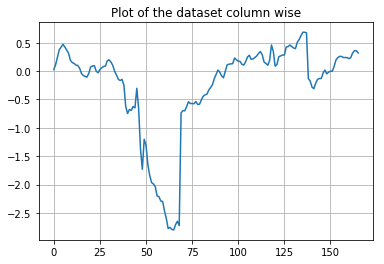

Network dimensions are 8 x 7 

Epoch : 0 completed 
 Max Bmu index : (0, 0)
Epoch : 1 completed 
 Max Bmu index : (0, 0)
Epoch : 2 completed 
 Max Bmu index : (0, 0)
Epoch : 3 completed 
 Max Bmu index : (0, 0)
Epoch : 4 completed 
 Max Bmu index : (0, 0)

 Training successfully completed 



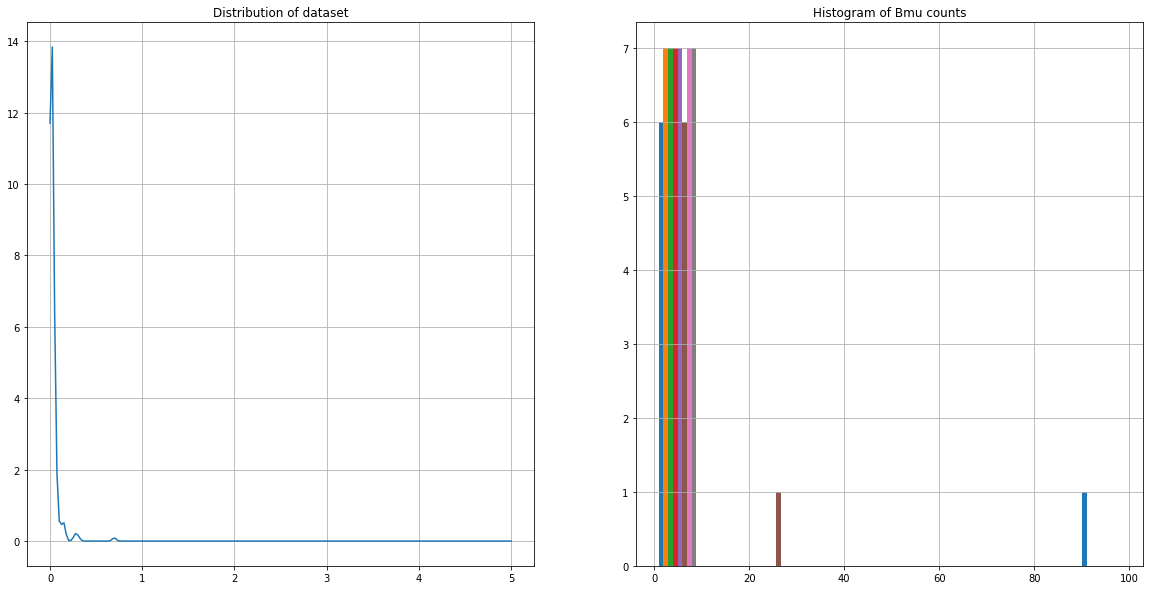

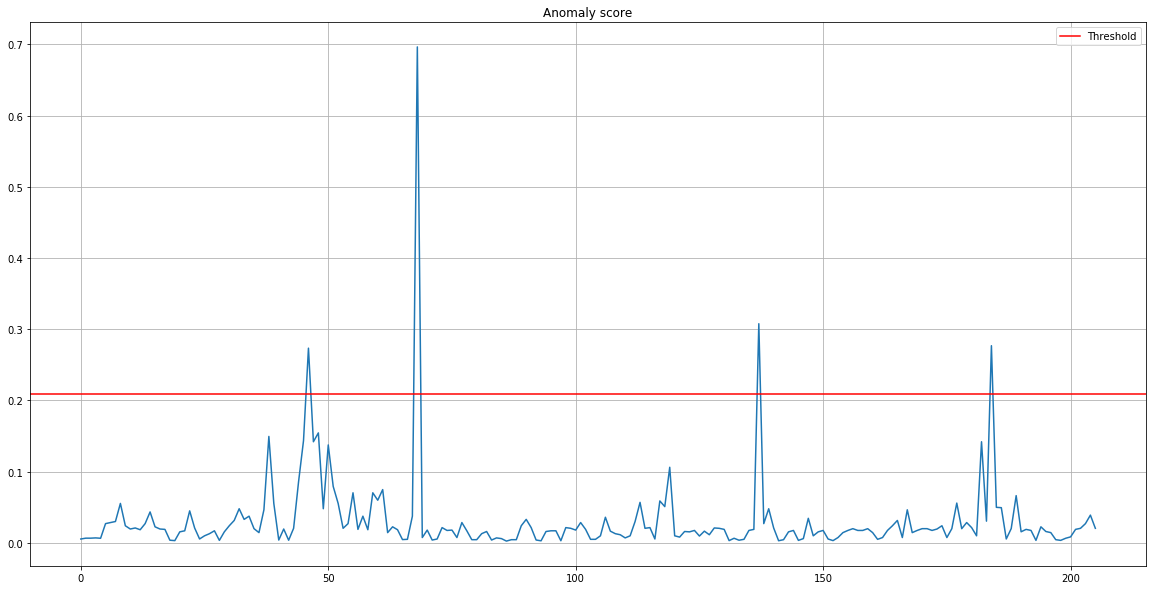

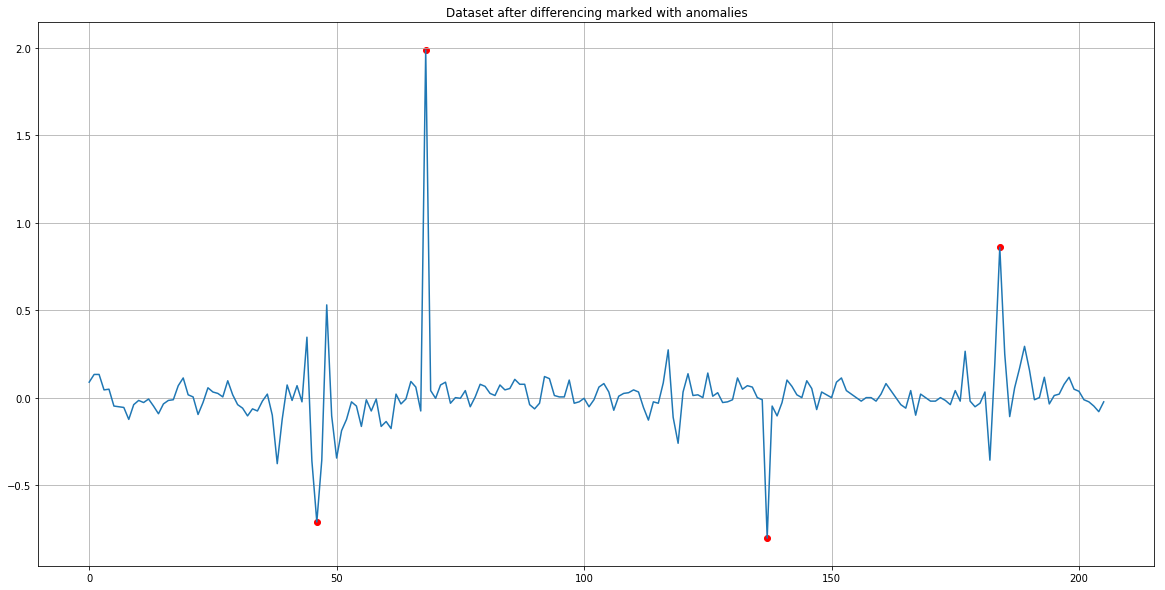

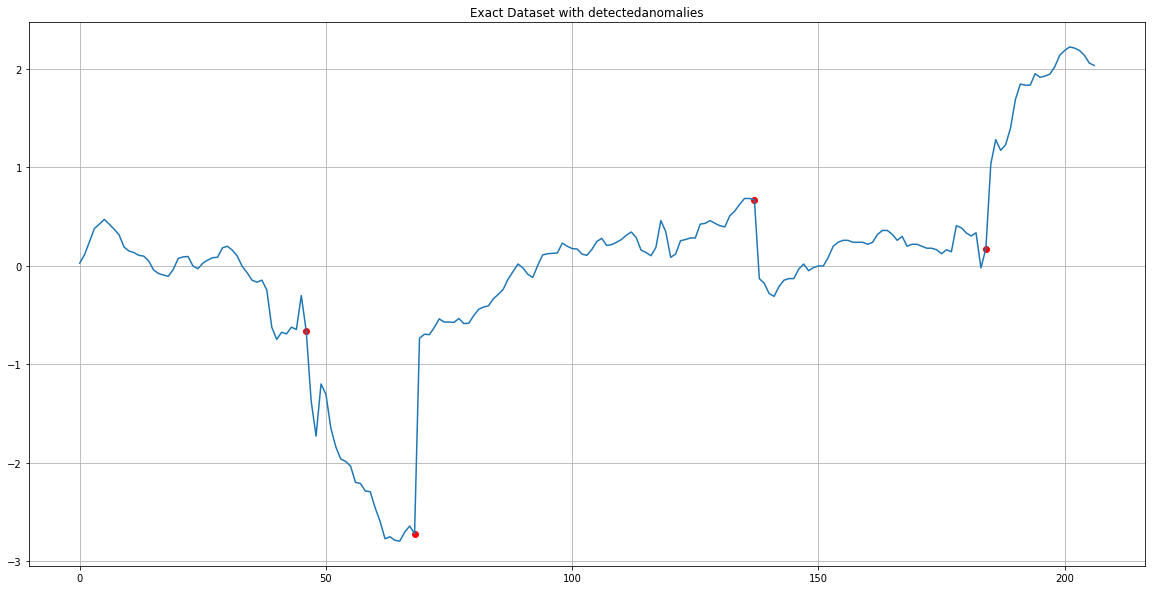

No of anomalies detected : 4, Fraction of data detected as anomaly : 0.01932367149758454

 No of Anomalies detected = 4
Postgres writer initialised 

{'code': '500', 'status': 'Unknown Exception', 'message': AttributeError("'Som_Detector' object has no attribute 'data_col_index'",)}

Detecting anomalies for average-annual-temperature-centr.csv

Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: 1 
            assetno  Average annual temperature, central England, 1723 ? 1970
timestamp                                                                   
0.0            1.0                                           0.920853       
0.0            1.0                                           0.089020       
0.0            1.0                                          -0.925817       
0.0            1.0                                           0.205476       
0.0            1.0                                           1.203676       

Shape of the dataset : 


Traceback (most recent call last):
  File "<ipython-input-6-a915133bb388>", line 143, in main
    res = writer.map_outputs_and_write()
  File "C:\Users\tr1109\intrototimeseries\tsfad\rohithram\rohithram-som-knn\som_knn\data_handler.py", line 130, in map_outputs_and_write
    queries = (self.make_query_args(self.anomaly_detectors[index],sql_query_args))
  File "C:\Users\tr1109\intrototimeseries\tsfad\rohithram\rohithram-som-knn\som_knn\data_handler.py", line 165, in make_query_args
    col_index = anomaly_detector.data_col_index
AttributeError: 'Som_Detector' object has no attribute 'data_col_index'


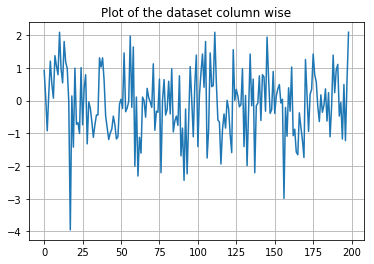

Network dimensions are 10 x 5 

Epoch : 0 completed 
 Max Bmu index : (0, 0)
Epoch : 1 completed 
 Max Bmu index : (0, 0)
Epoch : 2 completed 
 Max Bmu index : (0, 0)
Epoch : 3 completed 
 Max Bmu index : (0, 0)
Epoch : 4 completed 
 Max Bmu index : (0, 0)

 Training successfully completed 



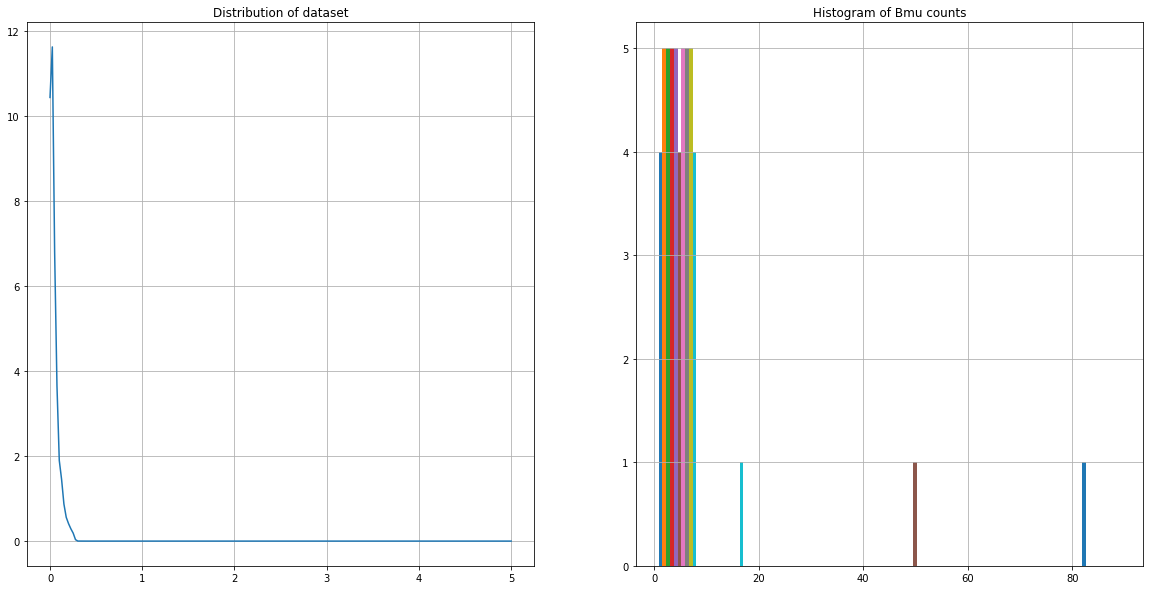

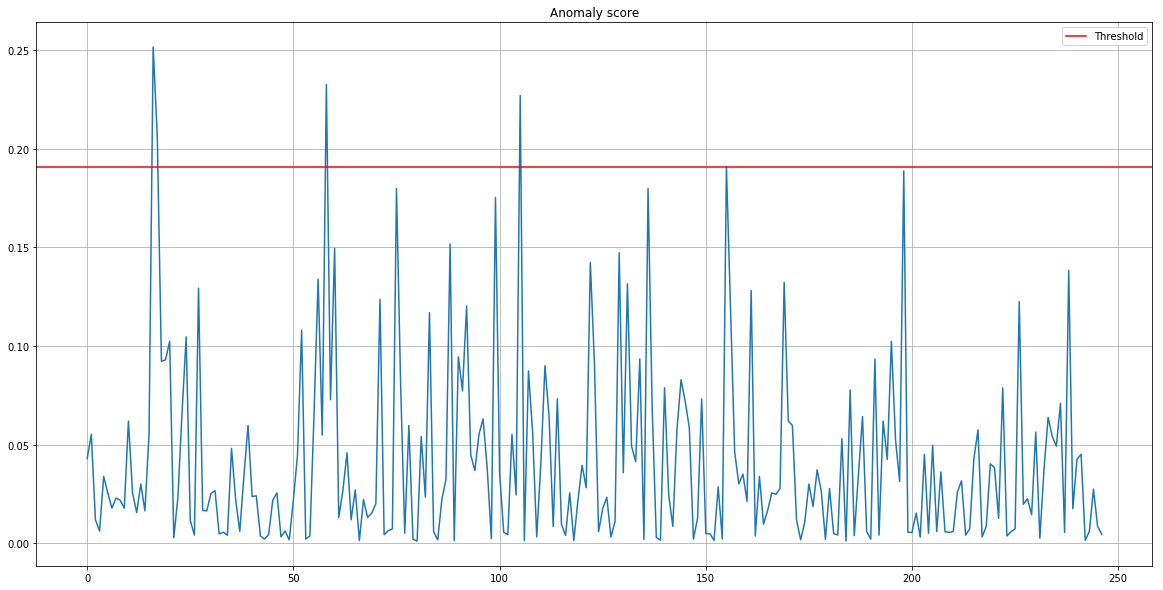

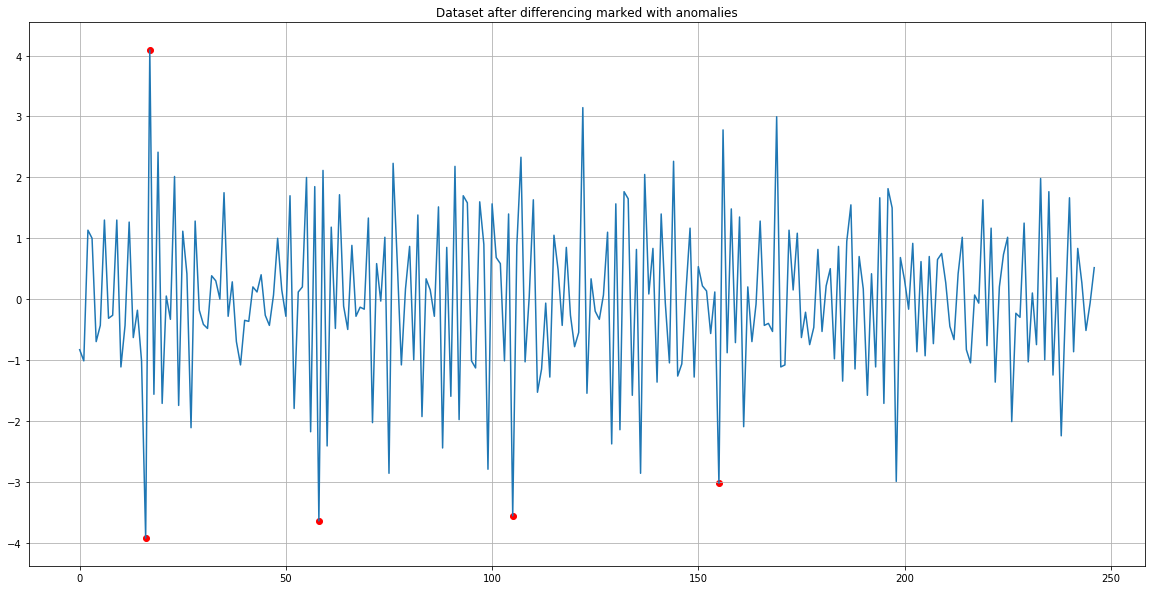

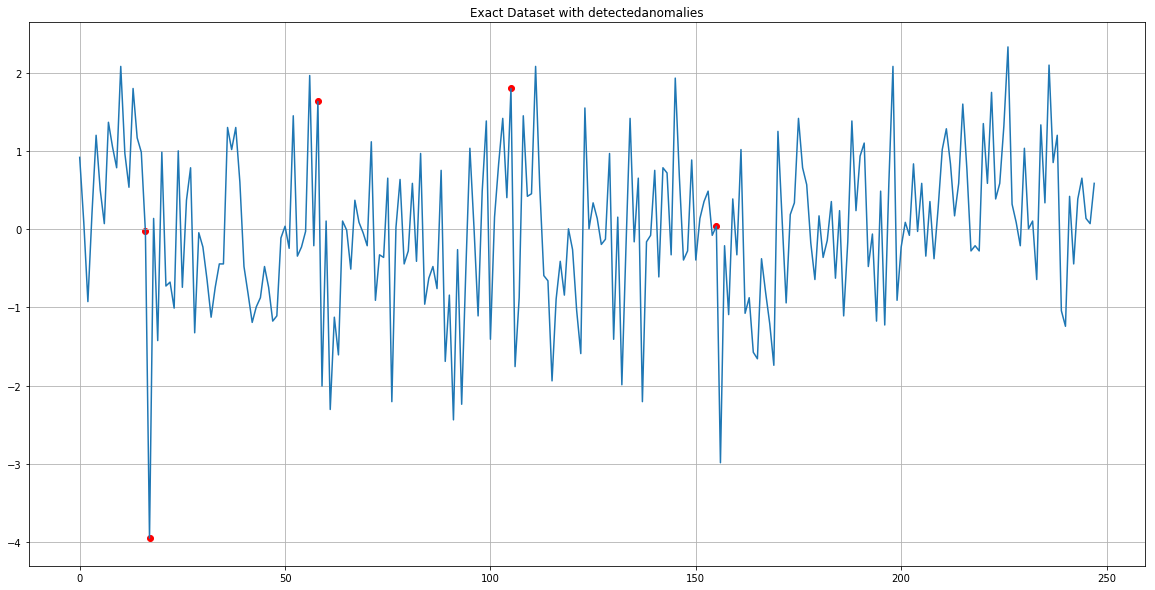

No of anomalies detected : 5, Fraction of data detected as anomaly : 0.020161290322580645

 No of Anomalies detected = 5
Postgres writer initialised 

{'code': '500', 'status': 'Unknown Exception', 'message': AttributeError("'Som_Detector' object has no attribute 'data_col_index'",)}

Detecting anomalies for mean-monthly-temperature-1907-19.csv

Data reader initialised 

Getting the dataset from the reader....



Traceback (most recent call last):
  File "<ipython-input-6-a915133bb388>", line 143, in main
    res = writer.map_outputs_and_write()
  File "C:\Users\tr1109\intrototimeseries\tsfad\rohithram\rohithram-som-knn\som_knn\data_handler.py", line 130, in map_outputs_and_write
    queries = (self.make_query_args(self.anomaly_detectors[index],sql_query_args))
  File "C:\Users\tr1109\intrototimeseries\tsfad\rohithram\rohithram-som-knn\som_knn\data_handler.py", line 165, in make_query_args
    col_index = anomaly_detector.data_col_index
AttributeError: 'Som_Detector' object has no attribute 'data_col_index'


Data of Asset no: 1 
                assetno  Mean monthly temperature, 1907 ? 1972
timestamp                                                    
-1.988150e+12      1.0                              -1.280625
-1.985472e+12      1.0                              -0.477613
-1.983053e+12      1.0                              -0.667301
-1.980374e+12      1.0                               0.091451
-1.977782e+12      1.0                              -0.110883

Shape of the dataset : 
torch.Size([792, 1])
torch.float64
Dataset has 634 rows 1 columns


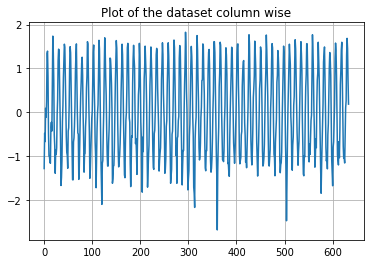

Network dimensions are 10 x 5 

Epoch : 0 completed 
 Max Bmu index : (0, 0)
Epoch : 1 completed 
 Max Bmu index : (0, 0)
Epoch : 2 completed 
 Max Bmu index : (0, 0)
Epoch : 3 completed 
 Max Bmu index : (0, 0)
Epoch : 4 completed 
 Max Bmu index : (0, 0)

 Training successfully completed 



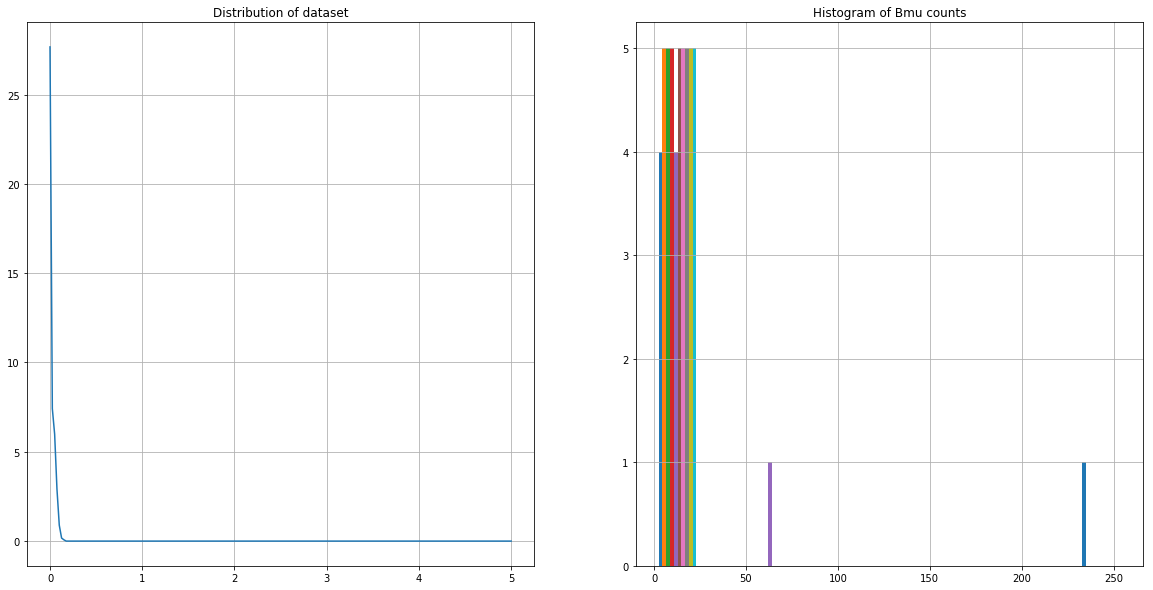

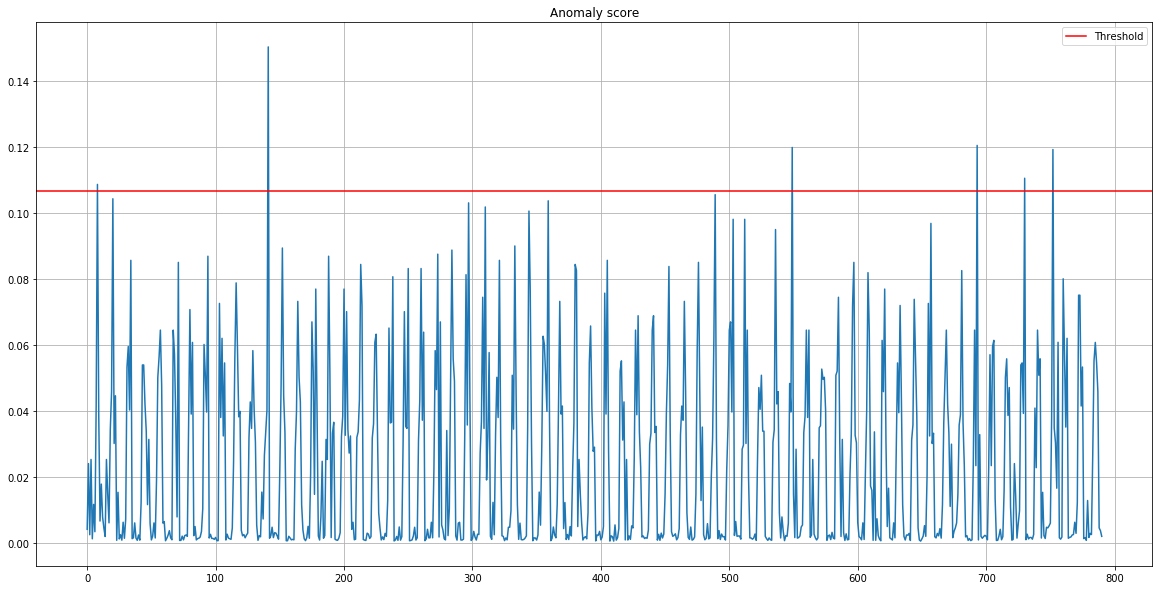

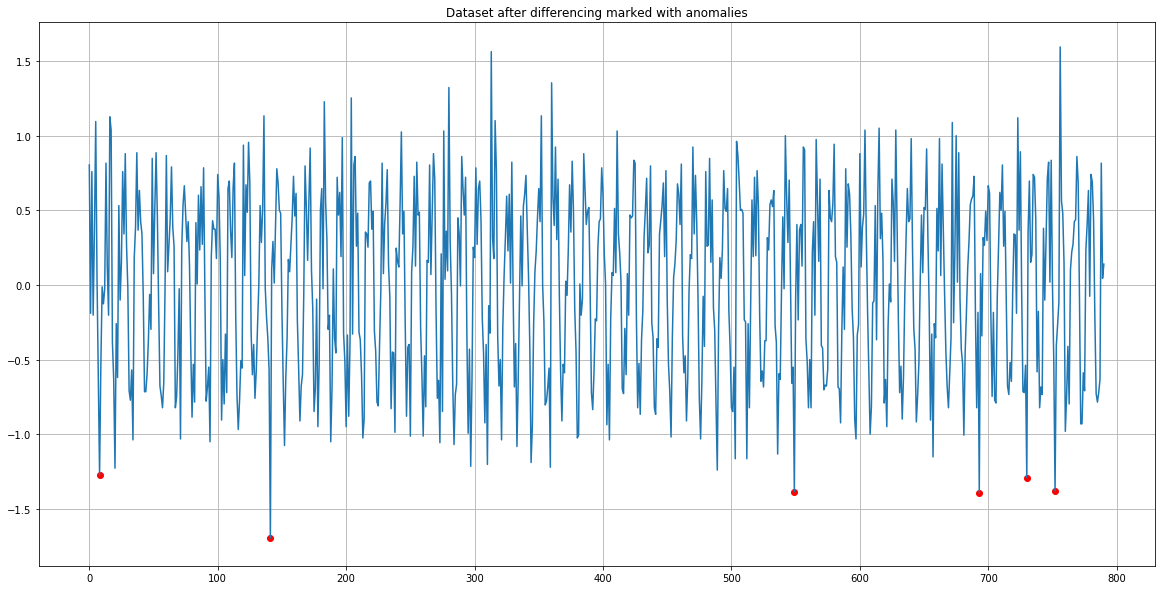

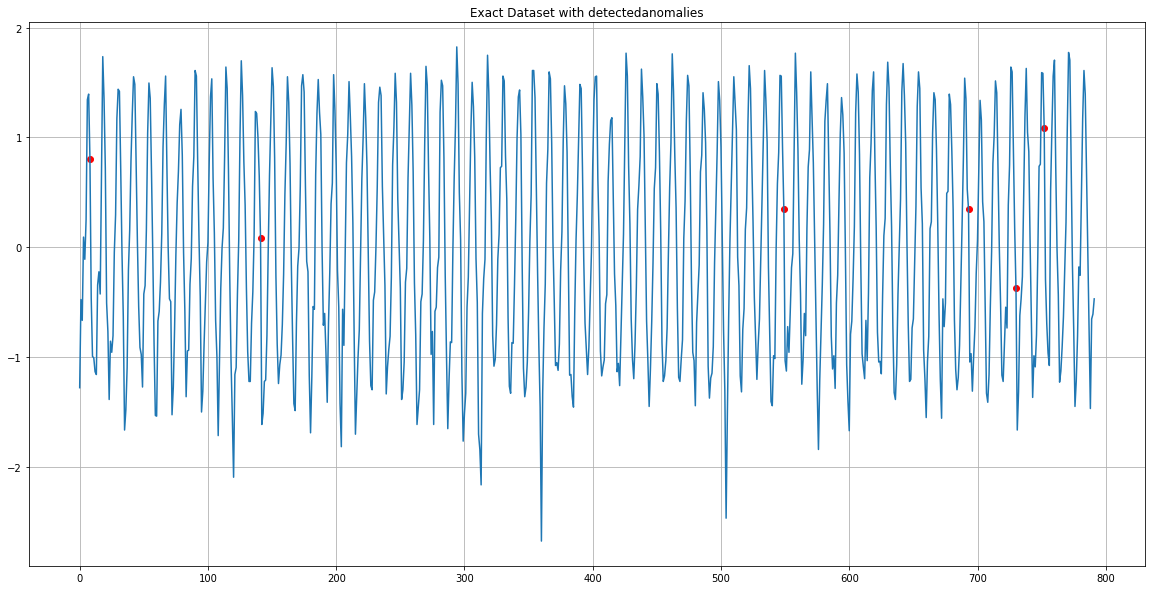

No of anomalies detected : 6, Fraction of data detected as anomaly : 0.007575757575757576

 No of Anomalies detected = 6
Postgres writer initialised 

{'code': '500', 'status': 'Unknown Exception', 'message': AttributeError("'Som_Detector' object has no attribute 'data_col_index'",)}

Detecting anomalies for methane-input-into-gas-furnace-c.csv

Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: 1 
               assetno       CO2   Methane
timestamp                                
7.808400e+12      1.0  0.090839 -1.170356
7.808940e+12      1.0  0.028381 -1.340206
7.809480e+12      1.0 -0.002849 -1.062837
7.810020e+12      1.0 -0.002849 -0.811959
7.810560e+12      1.0 -0.034078 -0.758978

Shape of the dataset : 
torch.Size([296, 2])
torch.float64
Dataset has 237 rows 2 columns


Traceback (most recent call last):
  File "<ipython-input-6-a915133bb388>", line 143, in main
    res = writer.map_outputs_and_write()
  File "C:\Users\tr1109\intrototimeseries\tsfad\rohithram\rohithram-som-knn\som_knn\data_handler.py", line 130, in map_outputs_and_write
    queries = (self.make_query_args(self.anomaly_detectors[index],sql_query_args))
  File "C:\Users\tr1109\intrototimeseries\tsfad\rohithram\rohithram-som-knn\som_knn\data_handler.py", line 165, in make_query_args
    col_index = anomaly_detector.data_col_index
AttributeError: 'Som_Detector' object has no attribute 'data_col_index'


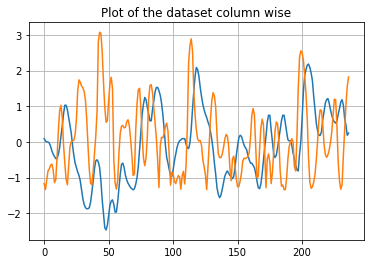

Network dimensions are 5 x 10 

Epoch : 0 completed 
 Max Bmu index : (0, 0)
Epoch : 1 completed 
 Max Bmu index : (0, 0)
Epoch : 2 completed 
 Max Bmu index : (0, 0)
Epoch : 3 completed 
 Max Bmu index : (0, 0)
Epoch : 4 completed 
 Max Bmu index : (0, 0)

 Training successfully completed 

{'code': '500', 'status': 'Unknown Exception', 'message': ValueError('query data dimension must match training data dimension',)}

Detecting anomalies for monthly-us-female-20-years-and-o.csv

Data reader initialised 



Traceback (most recent call last):
  File "<ipython-input-6-a915133bb388>", line 119, in main
    anom_indexes = anomaly_detector.detect_anomalies()
  File "C:\Users\tr1109\intrototimeseries\tsfad\rohithram\rohithram-som-knn\som_knn\som_knn_detector.py", line 84, in detect_anomalies
    anom_indexes = test(net,data_set[:,].numpy(),anom_thres=anom_thres,diff_order=diff_order)
  File "C:\Users\tr1109\intrototimeseries\tsfad\rohithram\rohithram-som-knn\som_knn\som_knn_detector.py", line 166, in test
    anomaly_metrics = net.evaluate(res_evaluateData) # Evaluate on the evaluateData data
  File "C:\Users\tr1109\intrototimeseries\tsfad\rohithram\rohithram-som-knn\som_knn\som_knn_module.py", line 132, in evaluate
    dist, _ = classifier.kneighbors(evaluationData)
  File "C:\Users\tr1109\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neighbors\base.py", line 385, in kneighbors
    for s in gen_even_slices(X.shape[0], n_jobs)
  File "C:\Users\tr1109\AppData\Local\Continuum\anacon

Getting the dataset from the reader....

Data of Asset no: 1 
                assetno  \
timestamp                
-6.943104e+11      1.0   
-6.916320e+11      1.0   
-6.891264e+11      1.0   
-6.864480e+11      1.0   
-6.838560e+11      1.0   

               Monthly U.S. female (20 years and over) unemployment figures (10**3) 1948-1981  
timestamp                                                                                      
-6.943104e+11                                          -1.351533                               
-6.916320e+11                                          -1.054180                               
-6.891264e+11                                          -1.138722                               
-6.864480e+11                                          -1.183908                               
-6.838560e+11                                          -1.285941                               

Shape of the dataset : 
torch.Size([408, 1])
torch.float64
Dataset has 327 rows 1

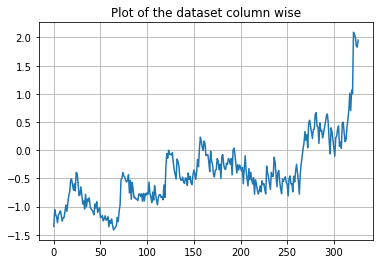

Network dimensions are 8 x 7 

Epoch : 0 completed 
 Max Bmu index : (0, 0)
Epoch : 1 completed 
 Max Bmu index : (0, 0)
Epoch : 2 completed 
 Max Bmu index : (0, 0)
Epoch : 3 completed 
 Max Bmu index : (0, 0)
Epoch : 4 completed 
 Max Bmu index : (0, 0)

 Training successfully completed 



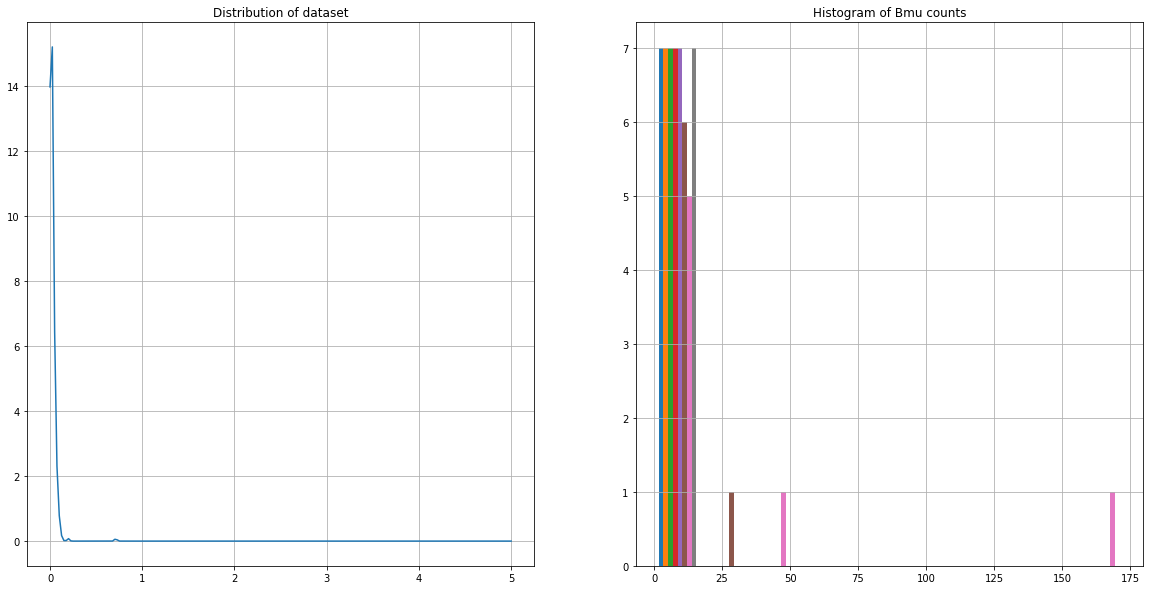

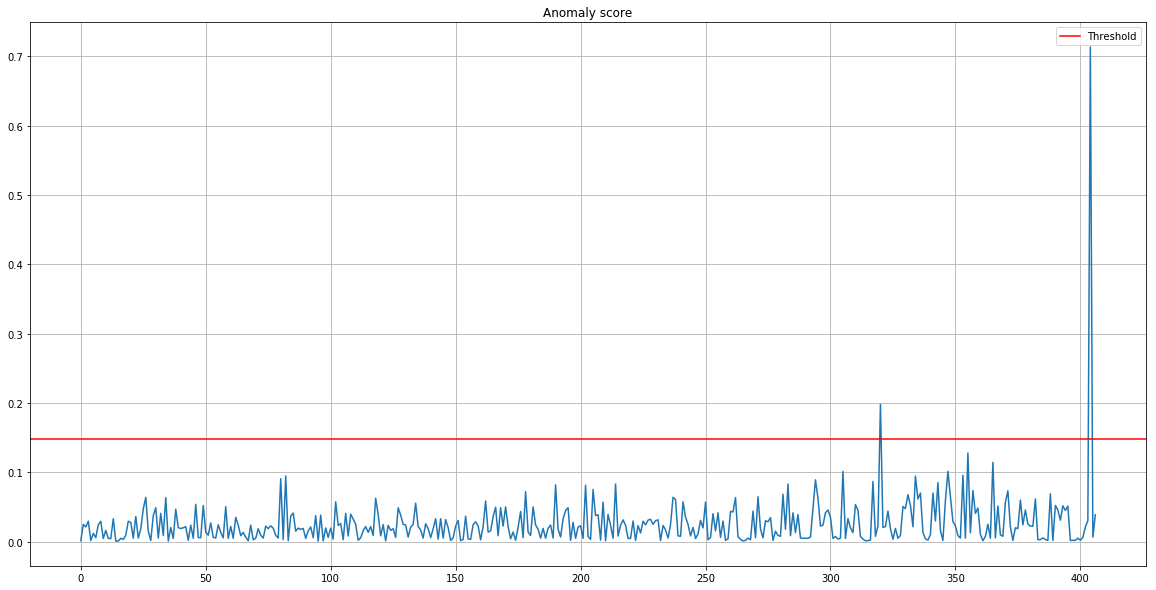

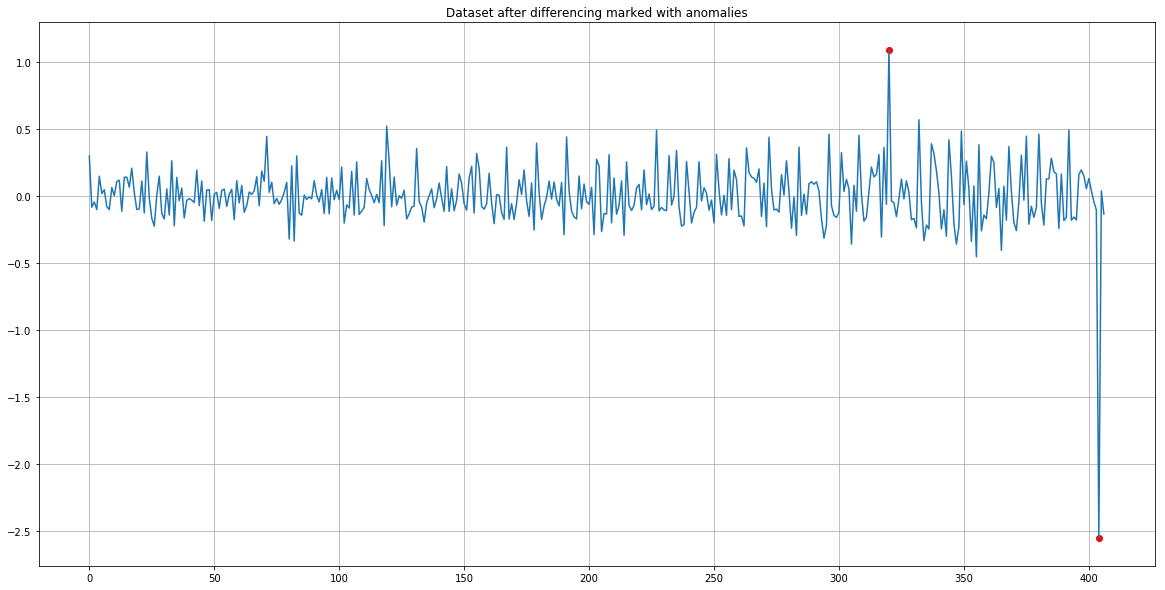

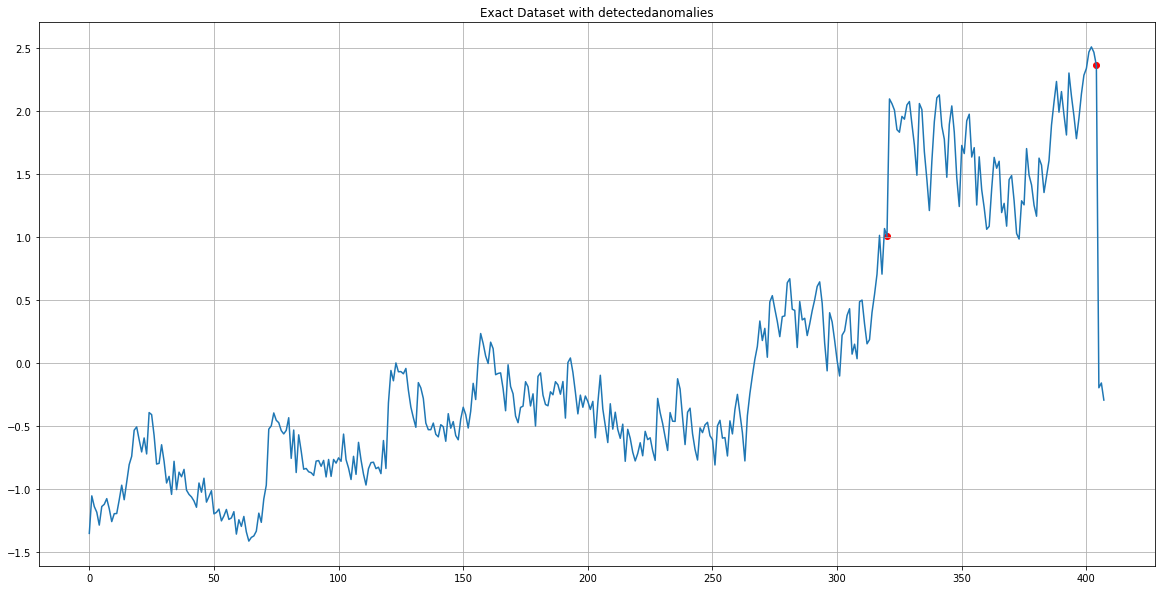

No of anomalies detected : 2, Fraction of data detected as anomaly : 0.004901960784313725

 No of Anomalies detected = 2
Postgres writer initialised 

{'code': '500', 'status': 'Unknown Exception', 'message': AttributeError("'Som_Detector' object has no attribute 'data_col_index'",)}

Detecting anomalies for winter-negative-temperature-sum-.csv

Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: 1 
            assetno  Winter negative temperature sum (in deg. C), 1781 ? 1988
timestamp                                                                   
0.0            1.0                                          -0.027888       
0.0            1.0                                          -0.507193       
0.0            1.0                                           2.003772       
0.0            1.0                                           2.091459       
0.0            1.0                                          -0.114832       

Shape of the dataset : 

Traceback (most recent call last):
  File "<ipython-input-6-a915133bb388>", line 143, in main
    res = writer.map_outputs_and_write()
  File "C:\Users\tr1109\intrototimeseries\tsfad\rohithram\rohithram-som-knn\som_knn\data_handler.py", line 130, in map_outputs_and_write
    queries = (self.make_query_args(self.anomaly_detectors[index],sql_query_args))
  File "C:\Users\tr1109\intrototimeseries\tsfad\rohithram\rohithram-som-knn\som_knn\data_handler.py", line 165, in make_query_args
    col_index = anomaly_detector.data_col_index
AttributeError: 'Som_Detector' object has no attribute 'data_col_index'


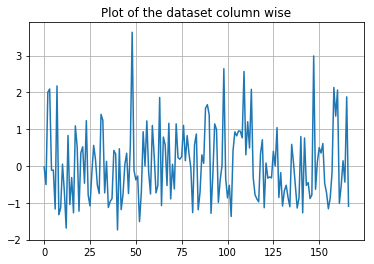

Network dimensions are 10 x 5 

Epoch : 0 completed 
 Max Bmu index : (0, 0)
Epoch : 1 completed 
 Max Bmu index : (0, 0)
Epoch : 2 completed 
 Max Bmu index : (0, 0)
Epoch : 3 completed 
 Max Bmu index : (0, 0)
Epoch : 4 completed 
 Max Bmu index : (0, 0)

 Training successfully completed 



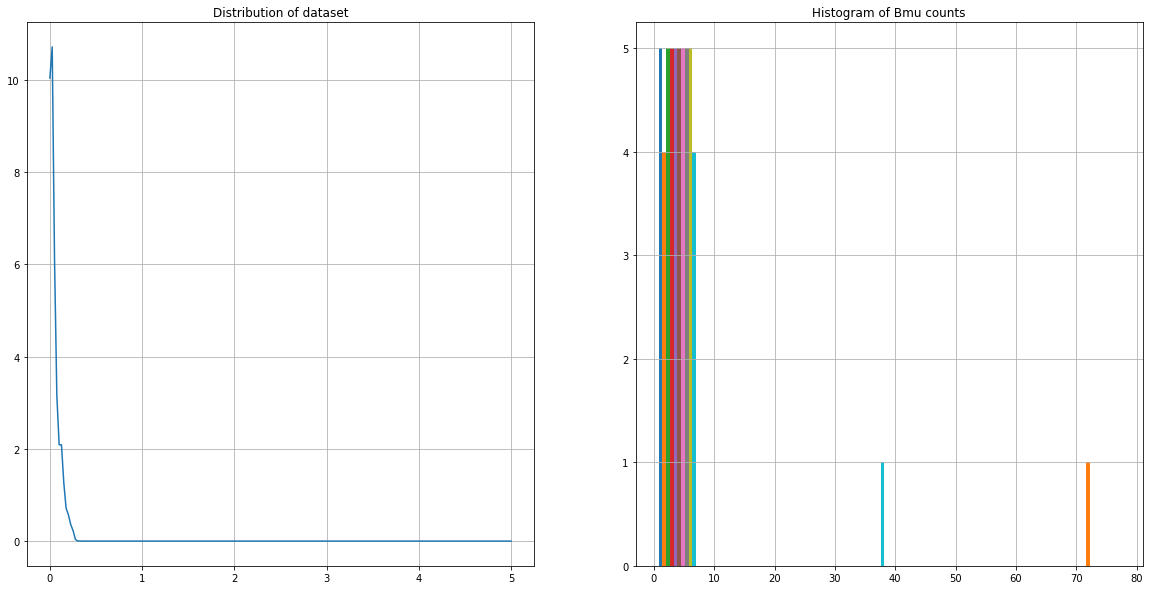

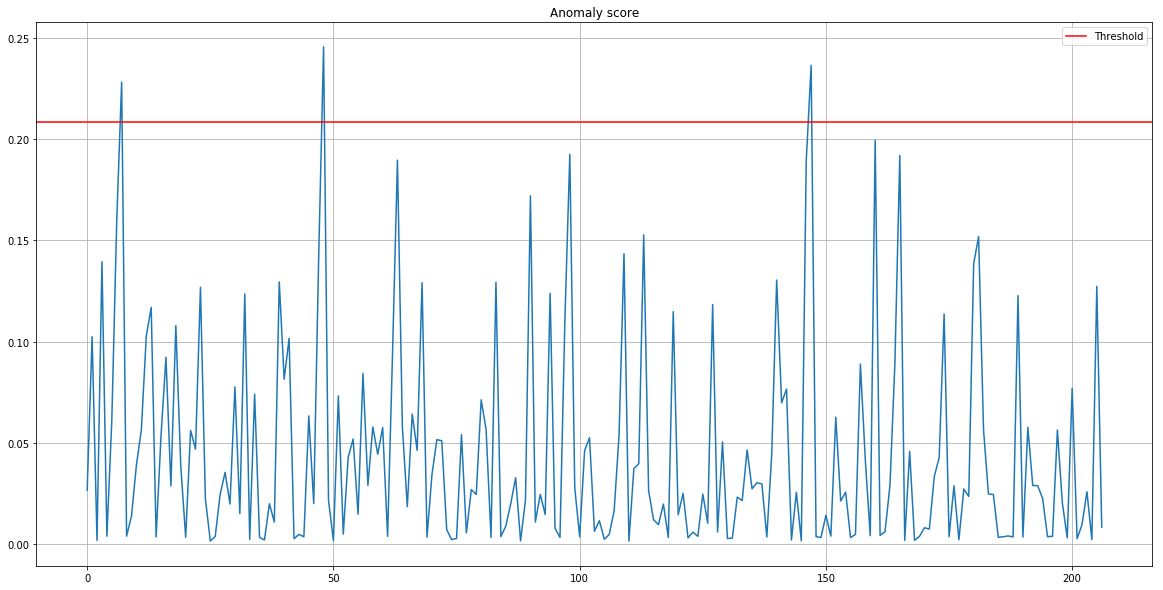

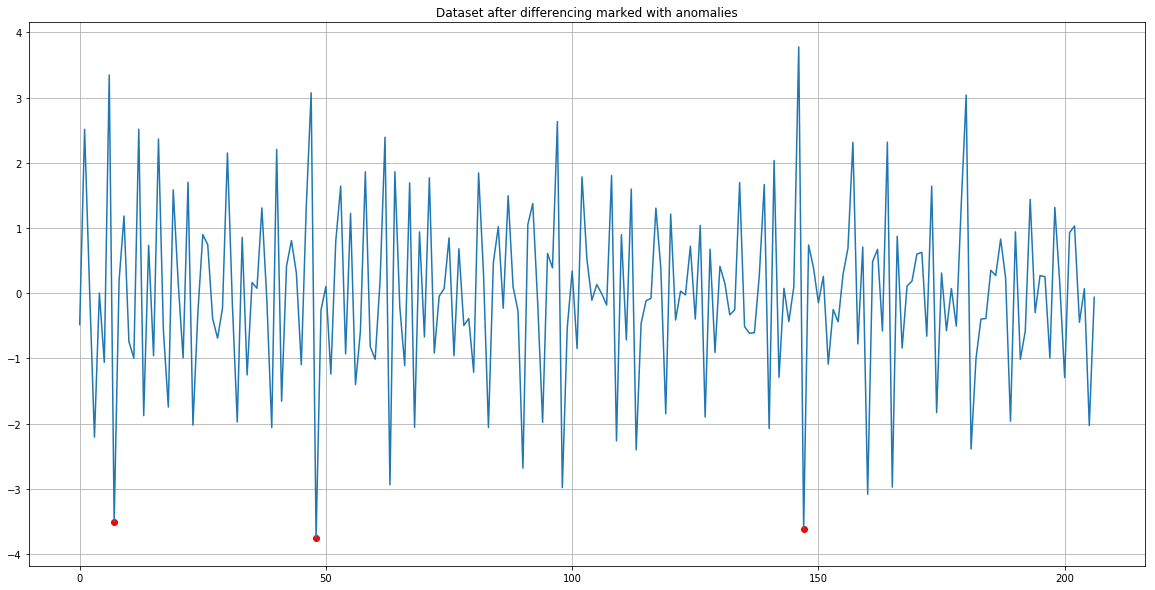

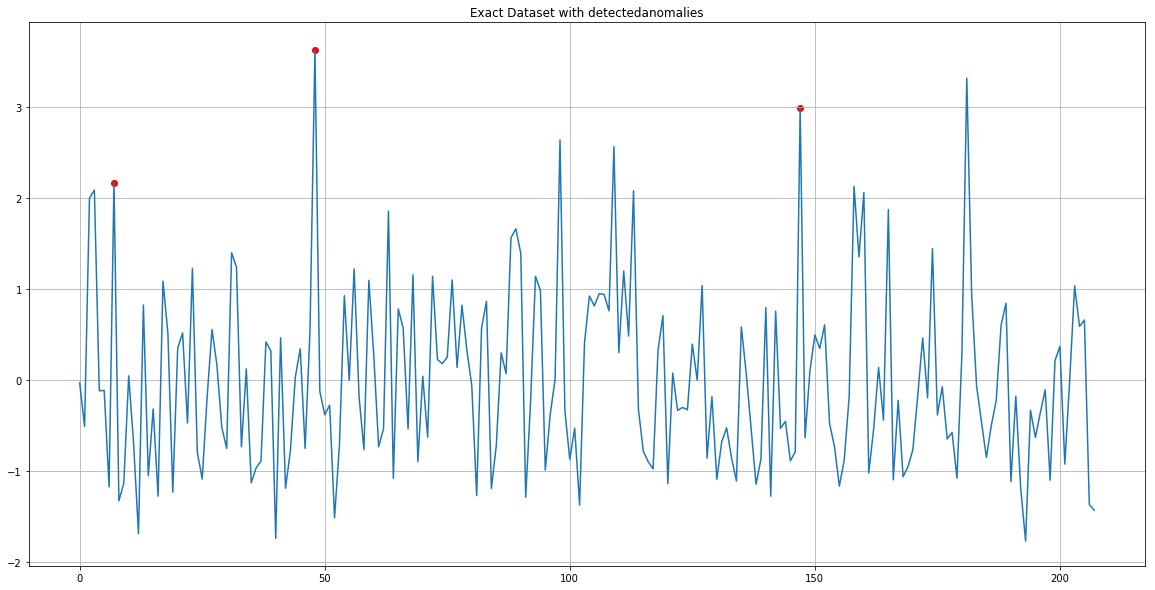

No of anomalies detected : 3, Fraction of data detected as anomaly : 0.014423076923076924

 No of Anomalies detected = 3
Postgres writer initialised 

{'code': '500', 'status': 'Unknown Exception', 'message': AttributeError("'Som_Detector' object has no attribute 'data_col_index'",)}


Traceback (most recent call last):
  File "<ipython-input-6-a915133bb388>", line 143, in main
    res = writer.map_outputs_and_write()
  File "C:\Users\tr1109\intrototimeseries\tsfad\rohithram\rohithram-som-knn\som_knn\data_handler.py", line 130, in map_outputs_and_write
    queries = (self.make_query_args(self.anomaly_detectors[index],sql_query_args))
  File "C:\Users\tr1109\intrototimeseries\tsfad\rohithram\rohithram-som-knn\som_knn\data_handler.py", line 165, in make_query_args
    col_index = anomaly_detector.data_col_index
AttributeError: 'Som_Detector' object has no attribute 'data_col_index'


In [12]:
data_dir = 'dataset/sample_csv_files/'
target_dir = 'dataset/reader_csv_files/'
assetno = ['1']
for filename in os.listdir(data_dir):
    
    name,ext = os.path.splitext(filename)
    if ext != '.csv':continue
    infile = os.path.join(data_dir,filename)
    print("\nDetecting anomalies for {}\n".format(filename))
    
    
    kwargs1 = get_csv_kwargs(infile=infile,filename=filename,target_dir=target_dir,assetno=assetno[0])
    
#     print('params: {}\n'.format(param))
    reader_kwargs1 = kwargs1
    model_input_args1 = model_input_args()
    training_args1 = training_args()
    kwargs1 = {**reader_kwargs1,**model_input_args1,**training_args1}
    res = main(**kwargs1,anom_thres=3)
    print(res)